# Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

In [6]:
import mlflow
import mlflow.sklearn
from pathlib import Path

In [7]:
MLFLOW_DIR = Path("../mlruns").resolve()
ARTIFACTS_DIR = Path("../configs/models").resolve()
mlflow.set_tracking_uri(f"file:///{str(MLFLOW_DIR)}")

In [8]:
BASE_EXPERIMENT_NAME = "Logistic_Regression"
mlflow.set_tracking_uri("../mlruns")

def set_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.set_experiment(experiment_name)

def create_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.create_experiment(experiment_name, artifact_location=f"file:///{str(ARTIFACTS_DIR)}")

In [6]:
def delete_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.delete_experiment(mlflow.get_experiment_by_name(experiment_name).experiment_id)

Number of rows in df_combined: 4072


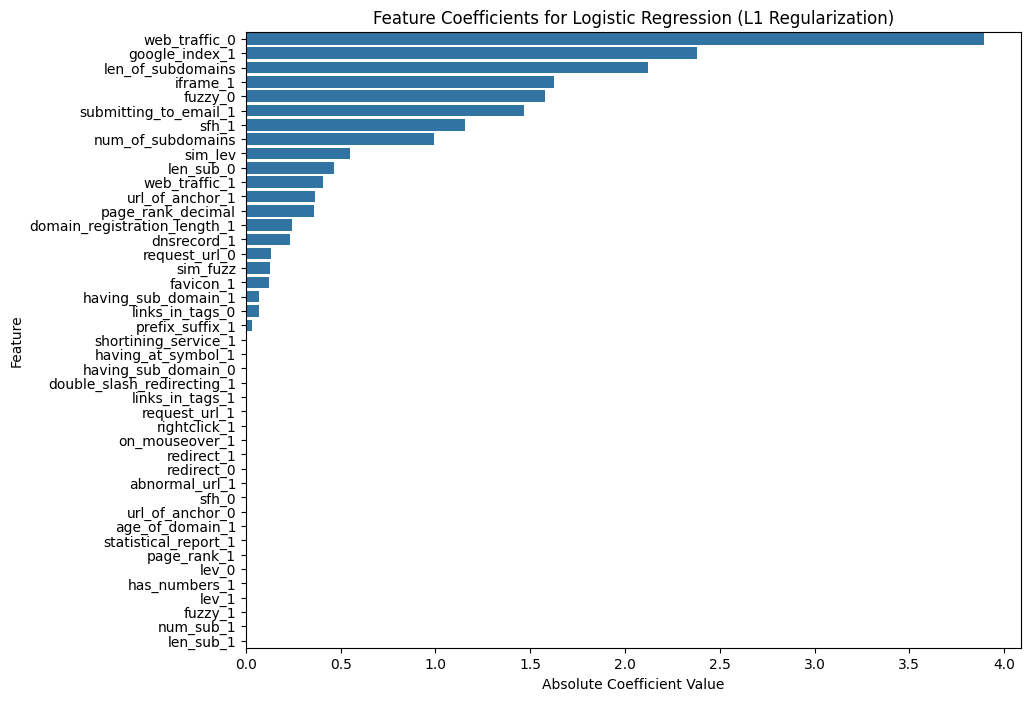

Selected features with non-zero coefficients: ['page_rank_decimal', 'sim_lev', 'sim_fuzz', 'num_of_subdomains', 'len_of_subdomains', 'prefix_suffix_1', 'having_sub_domain_1', 'domain_registration_length_1', 'favicon_1', 'request_url_0', 'url_of_anchor_1', 'links_in_tags_0', 'sfh_1', 'submitting_to_email_1', 'iframe_1', 'dnsrecord_1', 'web_traffic_0', 'web_traffic_1', 'google_index_1', 'fuzzy_0', 'len_sub_0']


In [3]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# %%
DATA_DIR = Path('../data')
COLLECTED_DIR = DATA_DIR / 'collected' / 'csv_scraped'
PROCESSED_DIR = DATA_DIR / 'processed'
PHISH_DATA = COLLECTED_DIR / 'phished.csv'
LEGIT_DATA = COLLECTED_DIR / 'valid.csv'

# %%
df_phish = pd.read_csv(PHISH_DATA)
df_valid = pd.read_csv(LEGIT_DATA)
df_phish['result'] = -1
df_valid['result'] = 1
df_combined = pd.concat([df_phish, df_valid], ignore_index=True)
df_combined.drop_duplicates(subset='website_url', inplace=True)
num_rows = df_combined.shape[0]
print(f"Number of rows in df_combined: {num_rows}")

# %%
drop_useless_features = {
    'id',                   # NOT NEEDED
    'timestamp',            # NOT NEEDED
    'open_rank_domain',     # NOT NEEDED
    'page_rank_integer',    # NOT NEEDED
    'website_url',          # NOT NEEDED
    'sslfinal_state',       # BAD
    'having_ip_address',    # USELESS
    'port',                 # USELESS
    'https_token',          # Not useful
    'special_characters',   # Not useful
    'url_length',
    'links_pointing_to_page',
}

df_combined.drop(columns=drop_useless_features, inplace=True)

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = df_combined.drop(columns=['result'])
y = df_combined['result']

continuous_cols = ['page_rank_decimal', 'sim_lev', 'sim_fuzz', 'num_of_subdomains', 'len_of_subdomains']
categorical_cols = [col for col in X.columns if col not in continuous_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),  # Scale continuous features
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # One-Hot encode categorical features
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=21))
])

pipeline.fit(X_train, y_train)

coefficients = pipeline.named_steps['model'].coef_[0]

transformed_columns = continuous_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))

feature_importance = pd.DataFrame({
    'Feature': transformed_columns,
    'Coefficient': coefficients
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Coefficients for Logistic Regression (L1 Regularization)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

selected_features = [transformed_columns[i] for i, coef in enumerate(coefficients) if coef != 0]
print("Selected features with non-zero coefficients:", selected_features)

X_transformed = preprocessor.fit_transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_columns)

final_data = pd.concat([X_transformed_df, y.reset_index(drop=True)], axis=1)

final_data = final_data[selected_features + ['result']]
final_data = final_data.sample(frac=1).reset_index(drop=True)
final_data.to_csv(PROCESSED_DIR/'final_lgr.csv', index=False)




In [9]:
DATA_DIR = Path('../data')
COLLECTED_DIR = DATA_DIR / 'collected' / 'csv_scraped'
PROCESSED_DIR = DATA_DIR / 'processed'
PHISH_DATA = COLLECTED_DIR / 'phished.csv'
LEGIT_DATA = COLLECTED_DIR / 'valid.csv'
df_phish = pd.read_csv(PHISH_DATA)
df_valid = pd.read_csv(LEGIT_DATA)
df_phish['result'] = -1
df_valid['result'] = 1
df_combined = pd.concat([df_phish, df_valid], ignore_index=True)
df_combined.drop_duplicates(subset='website_url', inplace=True)
num_rows = df_combined.shape[0]
print(f"Number of rows in df_combined: {num_rows}")
drop_useless_features = {
    'id',                   # NOT NEEDED
    'timestamp',            # NOT NEEDED
    'open_rank_domain',     # NOT NEEDED
    'page_rank_integer',    # NOT NEEDED
    'website_url',          # NOT NEEDED
    'sslfinal_state',       # BAD
    'having_ip_address',    # USELESS
    'port',                 # USELESS
    'https_token',          # Not useful
    'special_characters',   # Not useful
    'url_length',
    'links_pointing_to_page',
}

df_combined.drop(columns=drop_useless_features, inplace=True)

X = df_combined.drop(columns=['result'])
y = df_combined['result']

selected_features = ['page_rank_decimal', 'sim_lev', 'sim_fuzz', 'num_of_subdomains', 'len_of_subdomains', 'prefix_suffix', 'having_sub_domain', 'domain_registration_length', 'favicon', 'request_url', 'url_of_anchor', 'links_in_tags', 'sfh', 'submitting_to_email', 'iframe', 'dnsrecord', 'web_traffic', 'google_index', 'fuzzy', 'len_sub']

X = X[selected_features]

Number of rows in df_combined: 4072


# MLFlow

In [10]:
import mlflow
import mlflow.sklearn
from pathlib import Path

In [11]:
MLFLOW_DIR = Path("../mlruns").resolve()
ARTIFACTS_DIR = Path("../configs/models").resolve()
mlflow.set_tracking_uri(f"file:///{str(MLFLOW_DIR)}")

In [12]:
BASE_EXPERIMENT_NAME = "Logistic_Regression"

def set_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.set_experiment(experiment_name)

def create_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.create_experiment(experiment_name, artifact_location=f"file:///{str(ARTIFACTS_DIR)}")

In [13]:
def delete_experiment(experiment_name):
    experiment_name = f"{BASE_EXPERIMENT_NAME}_{experiment_name}"
    mlflow.delete_experiment(mlflow.get_experiment_by_name(experiment_name).experiment_id)

## Hyperparameter Tuning Libraries

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import time

In [15]:
hpo_run_count = 2
kfc_run_count = 2

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
param_grid = [
    {
        'model__solver': ['lbfgs'],
        'model__penalty': ['l2', None],  # Only include 'l2' and None with lbfgs
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__max_iter': [100, 200, 300]
    },
    {
        'model__solver': ['liblinear'],
        'model__penalty': ['l1', 'l2'],  # liblinear supports l1 and l2
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__max_iter': [100, 200, 300]
    }
]
continuous_cols = ['page_rank_decimal', 'sim_lev', 'sim_fuzz', 'num_of_subdomains', 'len_of_subdomains']
categorical_cols = [col for col in X.columns if col not in continuous_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

logreg = LogisticRegression(random_state=21)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', logreg)
])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [21]:
set_experiment("GRID_SEARCH")

with mlflow.start_run(run_name=f"HPO_{hpo_run_count}_LGR"):
    hpo_run_count += 1
    mlflow.log_param("model", "Logistic Regression")


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    y_test = y_test.values.ravel()
    y_train = y_train.values.ravel()
    
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    best_score = grid_search.best_score_
    mlflow.log_metric("best_accuracy", best_score)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_f1", f1)

    class_report = classification_report(y_test, y_pred)
    mlflow.log_param("classification_report", class_report)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    cm_image_path = "./images/confusion_matrix.png"
    plt.savefig(cm_image_path)
    plt.close()

    mlflow.log_artifact(cm_image_path, "confusion_matrix")

    mlflow.sklearn.log_model(best_model, "model")

    print("Best parameters found: ", best_params)
    print("Best cross-validation accuracy: {:.4f}".format(best_score))
    print("Test Accuracy: {:.4f}".format(accuracy))
    print("Test Precision: {:.4f}".format(precision))
    print("Test Recall: {:.4f}".format(recall))
    print("Test F1-Score: {:.4f}".format(f1))
    print("\nClassification Report:\n", class_report)
    print("\nConfusion Matrix:\n", cm)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


2024/11/20 18:24:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters found:  {'model__C': 100, 'model__max_iter': 200, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best cross-validation accuracy: 0.9589
Test Accuracy: 0.9423
Test Precision: 0.9351
Test Recall: 0.9377
Test F1-Score: 0.9364

Classification Report:
               precision    recall  f1-score   support

          -1       0.95      0.95      0.95       446
           1       0.94      0.94      0.94       369

    accuracy                           0.94       815
   macro avg       0.94      0.94      0.94       815
weighted avg       0.94      0.94      0.94       815


Confusion Matrix:
 [[422  24]
 [ 23 346]]
